In [1]:
import VariationalBayes as vb
import LogisticGLMM_lib as logit_glmm
import VariationalBayes.SparseObjectives as vb_sparse
import VariationalBayes.ExponentialFamilies as ef

import matplotlib.pyplot as plt
%matplotlib inline

import autograd
import numpy as np
import scipy as sp
from scipy import sparse

import copy
from scipy import optimize

import os
import json

import time

import pickle

analysis_name = 'simulated_data_small'
#analysis_name = 'criteo_subsampled'

data_dir = os.path.join(os.environ['GIT_REPO_LOC'],
                        'LinearResponseVariationalBayes.py/Models/LogisticGLMM/data')


In [2]:
pickle_output_filename = os.path.join(data_dir, '%s_python_vb_results.pkl' % analysis_name)
pkl_file = open(pickle_output_filename, 'rb')
vb_data = pickle.load(pkl_file)

json_filename = os.path.join(data_dir, '%s_stan_dat.json' % analysis_name)

json_file = open(json_filename, 'r')
json_dat = json.load(json_file)
json_file.close()

stan_dat = json_dat['stan_dat']

K = stan_dat['K'][0]
NObs = stan_dat['N'][0]
NG = stan_dat['NG'][0]
y_g_vec = np.array(stan_dat['y_group'])
y_vec = np.array(stan_dat['y'])
x_mat = np.array(stan_dat['x'])

glmm_par = logit_glmm.get_glmm_parameters(K=K, NG=NG)

# Define a class to contain prior parameters.
prior_par = logit_glmm.get_default_prior_params(K)
prior_par['beta_prior_mean'].set(np.array(stan_dat['beta_prior_mean']))

prior_par['beta_prior_info'].set(np.array(stan_dat['beta_prior_info']))

prior_par['mu_prior_mean'].set(stan_dat['mu_prior_mean'][0])
prior_par['mu_prior_info'].set(stan_dat['mu_prior_info'][0])

prior_par['tau_prior_alpha'].set(stan_dat['tau_prior_alpha'][0])
prior_par['tau_prior_beta'].set(stan_dat['tau_prior_beta'][0])



In [30]:
timer = glmm_lib.Timer()

{'No time': 2.1457672119140625e-05}


In [4]:
model = logit_glmm.LogisticGLMM(
    glmm_par, prior_par, x_mat, y_vec, y_g_vec, num_gh_points=vb_data['num_gh_points'])

glmm_par_draw = vb.ModelParamsDict('GLMM Parameter Draw')
glmm_par_draw.push_param(vb.ScalarParam('mu', val=0.0))
glmm_par_draw.push_param(vb.ScalarParam('tau', val=1.0))
glmm_par_draw.push_param(vb.VectorParam('beta', K, val=np.full(K, 0.)))
glmm_par_draw.push_param(vb.VectorParam('u', NG))

log_model = LogisticGLMMLogPosterior(glmm_par_draw, prior_par, x_mat, y_vec, y_g_vec)
log_model.get_log_posterior()

-42905.344740757813

In [5]:
class LogisticGLMMBootstrap(object):
    def __init__(self, model):
        self.model = model
        self.weights = np.full(model.x_mat.shape[0], 1.0)
        self.num_gh_points = 5
        self.model.set_gh_points(self.num_gh_points)
        
        self.get_weight_obs_jacobian = autograd.grad(
            self.get_data_log_lik_term)
        
        self.obs = 0
        
    def get_data_log_lik_term(self, free_par, obs):
        self.model.glmm_par.set_free(free_par)
        return logit_glmm.get_data_log_lik_terms(
                glmm_par = self.model.glmm_par,
                x_mat = np.atleast_2d(self.model.x_mat[obs, :]),
                y_vec = np.atleast_1d(self.model.y_vec[obs]),
                y_g_vec = np.atleast_1d(self.model.y_g_vec[obs]),
                gh_x = self.model.gh_x,
                gh_w = self.model.gh_w)[0]
    
    def get_weight_jacobian_list(self, free_par):
        weight_jacobian_list = []
        #np.full((self.model.x_mat.shape[0], len(free_par)), float('nan'))
        print('Running.')
        for obs in range(self.model.x_mat.shape[0]):
            if obs % 1000 == 0:
                print('Obs {}'.format(obs))
            weight_jacobian_list.append(self.get_weight_obs_jacobian(free_par, obs))
        print('Done.')
        return weight_jacobian_list
            
    def wrap_data_log_lik_terms(self, free_par):
        self.model.glmm_par.set_free(free_par)
        return self.model.get_data_log_lik_terms()

    def optimize_with_weights(self, weights, init_par, preconditioner, gtol=1e-6, print_every=1):
        self.model.use_weights = True
        self.model.weights = copy.deepcopy(weights)
        return self.model.tr_optimize_cond(
            init_par, preconditioner=preconditioner,
            num_gh_points=self.num_gh_points, gtol=gtol, print_every=print_every)   
    
    def get_model_weight_grad(self, free_par_vec, weights):
        self.model.use_weights = True
        self.model.weights = copy.deepcopy(weights)
        return self.model.objective.fun_free_grad(free_par_vec)

    
glmm_bootstrap_object = LogisticGLMMBootstrap(model)

glmm_par_free = vb_data['glmm_par_free']
elbo_hess = vb_sparse.unpack_csr_matrix(vb_data['elbo_hess_packed'])
moment_jac = vb_data['moment_jac']
print(elbo_hess.shape)

moment_wrapper = logit_glmm.MomentWrapper(glmm_par)


(10014, 10014)


In [6]:
elbo_hess = vb_sparse.unpack_csr_matrix(vb_data['elbo_hess_packed'])
preconditioner = sp.sparse.diags([1 / np.sqrt(-1. * elbo_hess.diagonal())], [0])
cond_init = sp.sparse.linalg.spsolve(preconditioner, glmm_par_free)


/usr/local/lib/python3.5/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:102: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


In [7]:
base_weights = np.full(NObs, 1.0)
print(np.sum(base_weights))
base_opt = glmm_bootstrap_object.optimize_with_weights(
    preconditioner=preconditioner,
    weights=base_weights, init_par=cond_init, gtol=1e-8)
base_free_par = glmm_bootstrap_object.model.objective.uncondition_x(base_opt.x)

61895.0
Iter  0  value:  23825.6902287
Iter  1  value:  23825.6899053
Iter  2  value:  23825.6898994
Iter  3  value:  23825.689899
Iter  4  value:  23825.689899
Optimization terminated successfully.
         Current function value: 23825.689899
         Iterations: 4
         Function evaluations: 5
         Gradient evaluations: 5
         Hessian evaluations: 0


In [31]:
timer.tic()
moment_jac = moment_wrapper.get_moment_jacobian(base_free_par)
timer.toc('moment_jac_time')

moment_jac_sp = sp.sparse.csr_matrix(moment_jac)

print('Time: ', timer.time_dict['moment_jac_time'])


Time:  7.490645170211792


In [32]:
# Get a sparse Jacobian.
# sparse_model = logit_glmm.SparseModelObjective(
#     model.glmm_par, model.prior_par, model.x_mat, model.y_vec, model.y_g_vec,
#     num_gh_points=model.num_gh_points, num_groups=1)

# sparse_model.glmm_par.set_free(model.glmm_par.get_free())
timer.tic()
weight_jacobian = model.get_sparse_weight_free_jacobian(base_free_par, print_every_n=200)
timer.toc('jac_time')

print('Jacobian time: ', timer.time_dict['weight_jac_time'])


Group 0 of 4999
Group 200 of 4999


KeyboardInterrupt: 

In [10]:
timer.tic()
kl_hess = model.get_sparse_free_hessian(base_free_par, print_every_n=200)
timer.toc('hess_time')
print('Hessian time: ', timer.time_dict['hess_time'])

Group 0 of 4999.
Group 200 of 4999.
Group 400 of 4999.
Group 600 of 4999.
Group 800 of 4999.
Group 1000 of 4999.
Group 1200 of 4999.
Group 1400 of 4999.
Group 1600 of 4999.
Group 1800 of 4999.
Group 2000 of 4999.
Group 2200 of 4999.
Group 2400 of 4999.
Group 2600 of 4999.
Group 2800 of 4999.
Group 3000 of 4999.
Group 3200 of 4999.
Group 3400 of 4999.
Group 3600 of 4999.
Group 3800 of 4999.
Group 4000 of 4999.
Group 4200 of 4999.
Group 4400 of 4999.
Group 4600 of 4999.
Group 4800 of 4999.


/home/rgiordan/Documents/git_repos/autograd/autograd/core.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


In [11]:
# Too bad you can't pickle sparse cholesky decomposition.

from scikits.sparse.cholmod import cholesky

timer.tic()
print('Cholesky:')
kl_hess_chol = cholesky(kl_hess)

print('Solve:')
param_boot_mat = -1 * kl_hess_chol.solve_A(weight_jacobian.T)

print('Done.')
timer.toc('inverse_time')


Cholesky:
Solve:


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  


Done.


In [24]:
# Evaluated at a linear combination of the bootstrap draw and base weights.
# Note that at the full bootstrap draw, the response is quite nonlinear.

use_jackknife = True
if use_jackknife:
    boot_draw = copy.deepcopy(base_weights)
    boot_draw[np.random.randint(NObs)] = 0.
else:
    boot_draw = np.random.multinomial(NObs, [1. / NObs] * NObs, size=1) - 1.0
    boot_draw = 1.0 * boot_draw + base_weights

print('Total weight (there are {} observations): {}'.format(NObs, np.sum(boot_draw)))

lr_boot_time = time.time()
lr_param_diff = param_boot_mat * (np.squeeze(boot_draw) - 1.0)
lr_boot_time = time.time() - lr_boot_time

print('lr_boot_time: ', lr_boot_time)

# Optionally, try taking a Newton step using the Hessian.
# model_weight_grad = glmm_bootstrap_object.get_model_weight_grad(
#     base_free_par + lr_param_diff, boot_draw)
# model_weight_grad_sp = sp.sparse.csc_matrix(np.expand_dims(model_weight_grad, axis=1))
# boot_newton_step_sp = kl_hess_chol.solve_A(model_weight_grad_sp)
# boot_newton_step = np.asarray(boot_newton_step_sp)
# print(np.max(np.abs(boot_newton_step)))

Total weight (there are 61895 observations): 61894.0
lr_boot_time:  0.7019197940826416


In [25]:
#preconditioner = sp.sparse.diags([1 / np.sqrt(kl_hess.diagonal())], [0])
cond_init = sp.sparse.linalg.spsolve(preconditioner, base_free_par + lr_param_diff)
# cond_init = sp.sparse.linalg.spsolve(preconditioner, base_free_par)

timer.tic()
glmm_par_opt_boot = glmm_bootstrap_object.optimize_with_weights(
    preconditioner=preconditioner,
    init_par=cond_init, weights=boot_draw, gtol=1e-8)
boot_free_par = model.objective.uncondition_x(glmm_par_opt_boot.x)
timer.toc('re_optimization_time')

print('Re-optimization time: ', re_opt_time)

/usr/local/lib/python3.5/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:102: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


Iter  0  value:  23825.6047797
Iter  1  value:  23825.6047789
Iter  2  value:  23825.6047789
Optimization terminated successfully.
         Current function value: 23825.604779
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
         Hessian evaluations: 0
Re-optimization time:  5.291572570800781


True param difference: 52.34891752735021
True moment norm difference: 41.069995134116205


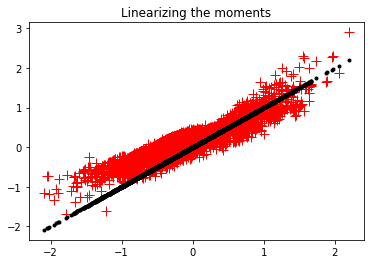

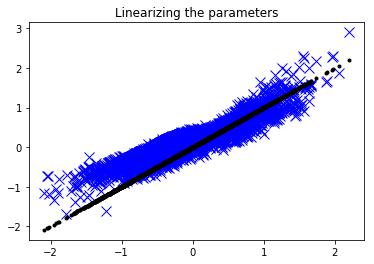

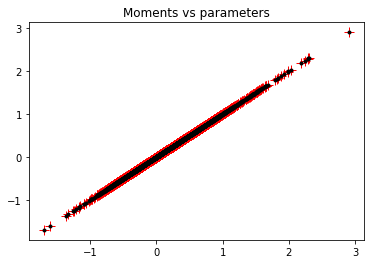

In [19]:
# The actual change in the moment vectors.
moment_vec = moment_wrapper.get_moment_vector_from_free(base_free_par)
moment_vec_boot = moment_wrapper.get_moment_vector_from_free(boot_free_par)
true_moment_diff = moment_vec_boot - moment_vec
print('True param difference: {}'.format(np.linalg.norm(base_free_par - boot_free_par)))
print('True moment norm difference: {}'.format(np.linalg.norm(true_moment_diff)))

# Use the linear approximation for the parameters, not the moments.
moment_pred_from_params = \
    moment_wrapper.get_moment_vector_from_free(base_free_par + lr_param_diff)
moment_pred_from_params_diff = moment_pred_from_params - moment_vec

# The difference based on a linear approximation to the moments.
# lr_moment_diff = \
#     moment_jac_sp * (param_boot_mat * (np.squeeze(boot_draw) - 1.0))
moment_pred_from_moments_diff = moment_jac_sp * lr_param_diff
    

plt.figure()
plt.title('Linearizing the moments')
plt.plot(true_moment_diff, moment_pred_from_moments_diff, 'r+', markersize=10)
plt.plot(true_moment_diff, true_moment_diff, 'k.')
#plt.axis([-10, 10, -10, 10])

plt.figure()
plt.title('Linearizing the parameters')
plt.plot(true_moment_diff, moment_pred_from_params_diff, 'bx', markersize=10)
plt.plot(true_moment_diff, true_moment_diff, 'k.')
#plt.axis([-10, 10, -10, 10])

plt.figure()
plt.title('Moments vs parameters')
plt.plot(moment_pred_from_params_diff, moment_pred_from_moments_diff, 'r+', markersize=10)
plt.plot(moment_pred_from_params_diff, moment_pred_from_params_diff, 'k.')
#plt.axis([-10, 10, -10, 10])



In [23]:
# Each column corresponds -1 times to a jackknife sample.
print(param_boot_mat.shape)
print()

def get_jackknife_moments(obs):
    lr_diff = np.squeeze(np.asarray(param_boot_mat[:, obs].todense()))
    return moment_wrapper.get_moment_vector_from_free(
        base_free_par - lr_diff)

timer.tic()
moment_par_jackknife_list = []
for obs in range(NObs):
    if obs % 5000 == 0:
        print('Obs {} of {}'.format(obs, NObs))
    moment_par_jackknife_list.append(get_jackknife_moments(obs))
timer.toc('lr_jackknife_time')

print('Jackknife time: ', timer.time_dict['lr_jackknife_time'])

(10014, 61895)

Obs 0 of 61895
Obs 5000 of 61895
Obs 10000 of 61895
Obs 15000 of 61895
Obs 20000 of 61895
Obs 25000 of 61895
Obs 30000 of 61895
Obs 35000 of 61895
Obs 40000 of 61895
Obs 45000 of 61895
Obs 50000 of 61895
Obs 55000 of 61895
Obs 60000 of 61895
Jackknife time:  39.53237175941467


In [ ]:
# Write the result to a JSON file for use in R.

run_name = 'jackknife'

pickle_output_filename = os.path.join(data_dir, '%s_python_vb_jackknife_results.pkl' % analysis_name)
pickle_output = open(pickle_output_filename, 'wb')

# Unlike with JSON, numpy arrays can be pickled.
pickle_result_dict = {  'moment_par_jackknife_list': moment_par_jackknife_list,
                        'run_name': run_name,
                        'timer': timer,
                        'base_free_par': base_free_par,
                        'boot_free_par': boot_free_par,
                        'boot_draw': boot_draw }

# Pickle dictionary using protocol 0.
pickle.dump(pickle_result_dict, pickle_output)
pickle_output.close()

print(pickle_output_filename)


print('\n\nDONE.')
